In [1]:
# Chess Board Training

In [18]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import numpy as np
import os
from ultralytics import YOLO


0: 480x800 1 0, 85.9ms
Speed: 6.0ms preprocess, 85.9ms inference, 10.0ms postprocess per image at shape (1, 3, 480, 800)


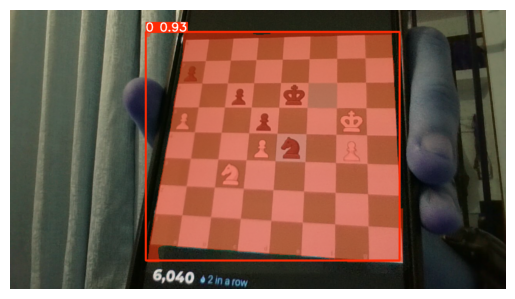

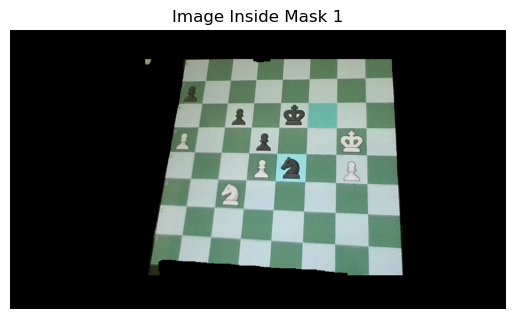

In [19]:
# Load the YOLO model
model_path = os.path.join('.', 'runs', 'segment', 'train_CB', 'weights', 'best.pt')
model = YOLO(model_path)

# Load the image
image_path = "C:/Users/Daithoulung Rongmai/Pictures/Camera Roll/WIN_20241021_23_19_44_Pro.jpg"
img = Image.open(image_path)

# Run inference
results = model.predict(img, conf=0.8)

# Display results
for result in results:
    img_np = result.plot() if hasattr(result, 'plot') else result  
    plt.imshow(img_np)
    plt.axis('off')
    plt.show()

    if hasattr(result, 'masks'):
        # Extract the mask data
        masks = result.masks.data.cpu().numpy()  # Get the masks and convert to NumPy array
        
        # Iterate over masks
        for i in range(masks.shape[0]):
            mask = masks[i]

            # Convert mask to binary (0, 255) for visualization
            mask_binary = (mask * 255).astype(np.uint8)

            # Resize mask to match the original image size
            mask_binary_resized = cv2.resize(mask_binary, (img_np.shape[1], img_np.shape[0]), interpolation=cv2.INTER_NEAREST)

            # Extract the image inside the mask
            img_np = np.array(img)  # Convert PIL image to NumPy array
            masked_image = cv2.bitwise_and(img_np, img_np, mask=mask_binary_resized)

            # Display the masked image
            plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct display
            plt.title(f'Image Inside Mask {i + 1}')
            plt.axis('off')
            plt.show()
    else:
        print("No masks found in the results.")


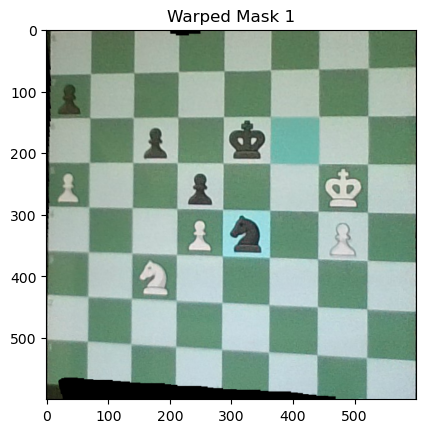

In [20]:

for result in results:
    img_np = result.plot() if hasattr(result, 'plot') else result  

    if hasattr(result, 'masks'):
        # Extract the mask data
        masks = result.masks.data.cpu().numpy()  # Get the masks and convert to NumPy array
        
        # Iterate over masks
        for i in range(masks.shape[0]):
            mask = masks[i]

            # Convert mask to binary (0, 255) for visualization
            mask_binary = (mask * 255).astype(np.uint8)

            # Resize mask to match the original image size
            mask_binary_resized = cv2.resize(mask_binary, (img_np.shape[1], img_np.shape[0]), interpolation=cv2.INTER_NEAREST)

            # Extract the image inside the mask
            img_np = np.array(img)  # Convert PIL image to NumPy array
            masked_image = cv2.bitwise_and(img_np, img_np, mask=mask_binary_resized)

            # Find contours of the mask
            contours, _ = cv2.findContours(mask_binary_resized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Get the largest contour, assuming it corresponds to the object of interest
            if contours:
                largest_contour = max(contours, key=cv2.contourArea)

                # Approximate the contour to get the corners
                epsilon = 0.02 * cv2.arcLength(largest_contour, True)
                approx_corners = cv2.approxPolyDP(largest_contour, epsilon, True)

                if len(approx_corners) == 4:  # We need 4 corners for perspective transformation
                    src_pts = np.array([pt[0] for pt in approx_corners], dtype="float32")

                    # Define destination points for the top-down view (e.g., 600x600)
                    dst_pts = np.array([[0, 0], [600, 0], [600, 600], [0, 600]], dtype="float32")

                    # Compute the perspective transform matrix
                    M = cv2.getPerspectiveTransform(src_pts, dst_pts)

                    # Apply the warp perspective transformation
                    warped_mask = cv2.warpPerspective(masked_image, M, (600, 600))
                    
                    rotated_mask= cv2.rotate(warped_mask, cv2.ROTATE_90_CLOCKWISE)

                    mirrored_mask = cv2.flip(rotated_mask, 1)

                    plt.imshow(cv2.cvtColor(mirrored_mask, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct display
                    plt.title(f'Warped Mask {i + 1}')
                    # plt.axis('off')
                    plt.show()
                else:
                    print("Could not find 4 corners for perspective transformation.")
            else:
                print("No contours found for the mask.")
    else:
        print("No masks found in the results.")



0: 800x800 1 black-king, 1 black-knight, 3 black-pawns, 1 white-king, 1 white-knight, 3 white-pawns, 42.1ms
Speed: 7.0ms preprocess, 42.1ms inference, 3.0ms postprocess per image at shape (1, 3, 800, 800)


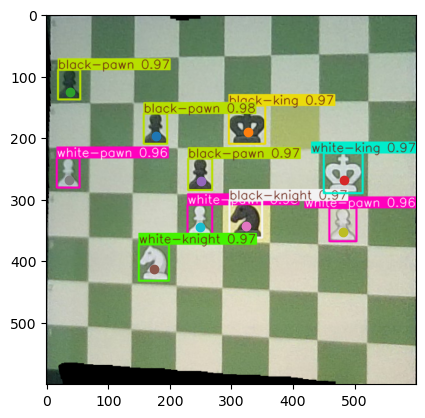

[[177.53009033203125, 195.81373596191406, 3], [326.0843505859375, 189.68948364257812, 1], [37.80723571777344, 124.40478515625, 3], [482.27911376953125, 267.8068542480469, 7], [250.06288146972656, 269.9939270019531, 3], [174.91519165039062, 412.9764099121094, 8], [323.9689636230469, 342.5037841796875, 2], [36.138328552246094, 267.49591064453125, 9], [481.3202819824219, 351.5572509765625, 9], [249.49169921875, 344.88848876953125, 9]]


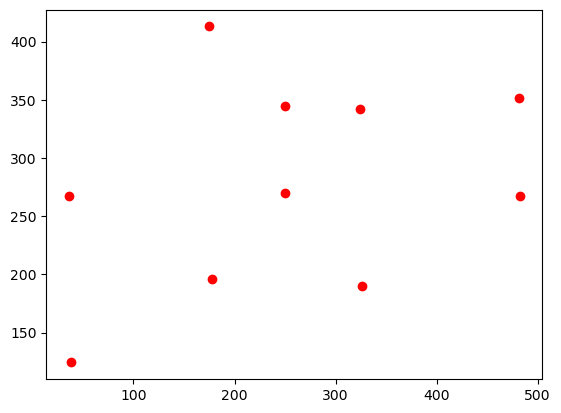

In [21]:
model_path = os.path.join('.', 'runs', 'detect', 'train_GCP', 'weights', 'best.pt')
model = YOLO(model_path)

results = model.predict(mirrored_mask, conf=0.3)
CA1 = []
custom = 10
for result in results:
    boxes = result.boxes.xyxy.cpu().numpy()
    classes = result.boxes.cls.cpu().numpy()
    for box, class_id in zip(boxes, classes):
        CA2 = []
        x_min, y_min, x_max, y_max = box
        center_x = (x_min + x_max) / 2
        center_y = ((y_min + y_max) / 2) + custom
        plt.scatter(center_x, center_y)
        CA2.append(center_x)
        CA2.append(center_y)
        CA2.append(int(class_id))
        CA1.append(CA2)
        
img_np1 = result.plot()
plt.imshow(img_np1)
# plt.axis('off')
plt.show()
print(CA1)
for i in range(len(CA1)):
    plt.scatter(CA1[i][0], CA1[i][1], c='red')


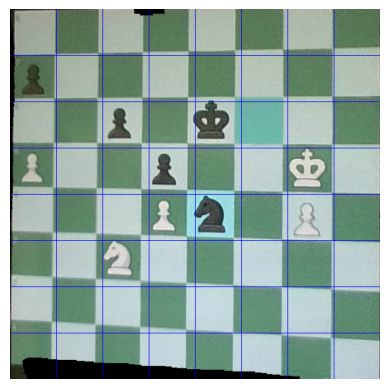

In [22]:

grid_size = 600  # We'll map the warped image to a 600x600 square

rows = 8
cols = 8

# Calculate the width and height of each cell in the grid
cell_width = grid_size // cols
cell_height = grid_size // rows

# Copy the warped image to draw the grid
img_with_grid = mirrored_mask.copy()

# Draw horizontal lines for the grid
for i in range(1, rows):
    y = i * cell_height
    cv2.line(img_with_grid, (0, y), (grid_size, y), (255, 0, 0), 1)  # Horizontal line

# Draw vertical lines for the grid
for i in range(1, cols):
    x = i * cell_width
    cv2.line(img_with_grid, (x, 0), (x, grid_size), (255, 0, 0), 1)  # Vertical line

# Display the warped image with the grid
plt.imshow(cv2.cvtColor(img_with_grid, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct display in Matplotlib
plt.axis('off')  # Remove axis for a clean display
plt.show()


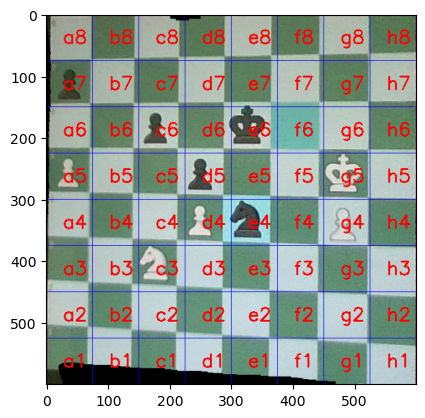

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Assume previous code created warped_image and grid dimensions
rows, cols = 8, 8
grid_size = 600
cell_width = grid_size // cols
cell_height = grid_size // rows

# Chessboard column labels ('a' to 'h') and row labels ('1' to '8')
columns = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
rows_labels = ['1', '2', '3', '4', '5', '6', '7', '8']

# Reverse the row labels to make sure bottom-left is 'a1'
rows_labels.reverse()

# Copy the warped image to draw labels
img_with_labels = img_with_grid.copy()

# Iterate over each cell in the grid
for i in range(rows):
    for j in range(cols):
        # Calculate the top-left corner of the current cell
        x = i * cell_width
        y = j * cell_height

        # Generate the corresponding chessboard label
        label = columns[i] + rows_labels[j]

        # Place the label at the center of the cell
        text_x = x + cell_width // 2 - 10  # Adjust for text alignment
        text_y = y + cell_height // 2 + 10  # Adjust for text alignment

        # Add the label to the image (white text with font size 1)
        cv2.putText(img_with_labels, label, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

# Display the warped image with grid and labels
plt.imshow(cv2.cvtColor(img_with_labels, cv2.COLOR_BGR2RGB))
plt.show()


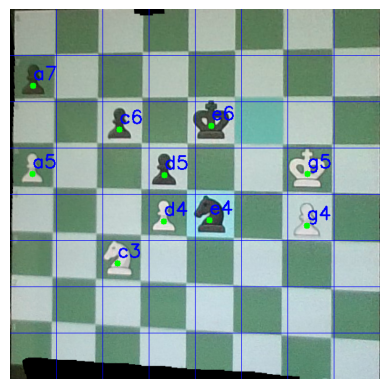

In [24]:
res = img_with_grid.copy()

piece_positions = {}

for result in results:
    boxes = result.boxes.xyxy.cpu().numpy()
    classes = result.boxes.cls.cpu().numpy()
    names = result.names
    for itr in range(len(CA1)):
        center_x = CA1[itr][0]
        center_y = CA1[itr][1]
        
        grid_col = int(center_x // cell_width)
        grid_row = int(center_y // cell_height)
        
        if 0 <= grid_col < cols and 0 <= grid_row < rows:
            # Get the corresponding grid label
            grid_label = columns[grid_col] + rows_labels[grid_row]

            # Store the piece position and type in the dictionary
            piece_positions[grid_label] = names[CA1[itr][2]]  # Correctly map label to class name
            
            cv2.circle(res, (int(center_x), int(center_y)), 5, (0, 255, 0), -1)
            cv2.putText(res, grid_label, (int(center_x), int(center_y) - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
        else:
            print(f"Center point ({center_x}, {center_y}) is outside the grid bounds.")

plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()



A black-pawn is located in a7.
A white-pawn is located in a5.
A black-pawn is located in c6.
A white-knight is located in c3.
A black-pawn is located in d5.
A white-pawn is located in d4.
A black-king is located in e6.
A black-knight is located in e4.
A white-king is located in g5.
A white-pawn is located in g4.


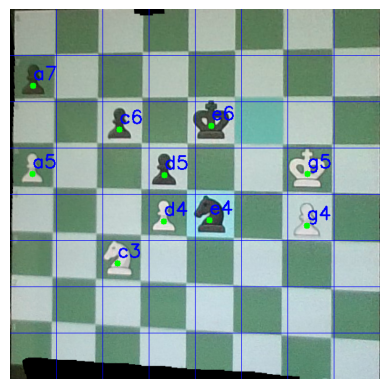

In [25]:
def check_piece_in_cell(cell_label):
    if cell_label in piece_positions:
        return f"A {piece_positions[cell_label]} is located in {cell_label}."
    else:
        return

for i in range(rows):
    for j in range(cols):
        # Calculate the top-left corner of the current cell
        x = j * cell_width
        y = i * cell_height

        # Generate the corresponding chessboard label
        label = columns[i] + rows_labels[j]
        if check_piece_in_cell(label) != None:
            print(check_piece_in_cell(label))
        

# Display the final image with the grid and labels
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [26]:
import chess

piece_map = {
    'white-rook': chess.Piece(chess.ROOK, chess.WHITE),
    'white-knight': chess.Piece(chess.KNIGHT, chess.WHITE),
    'white-bishop': chess.Piece(chess.BISHOP, chess.WHITE),
    'white-queen': chess.Piece(chess.QUEEN, chess.WHITE),
    'white-king': chess.Piece(chess.KING, chess.WHITE),
    'white-pawn': chess.Piece(chess.PAWN, chess.WHITE),
    'black-rook': chess.Piece(chess.ROOK, chess.BLACK),
    'black-knight': chess.Piece(chess.KNIGHT, chess.BLACK),
    'black-bishop': chess.Piece(chess.BISHOP, chess.BLACK),
    'black-queen': chess.Piece(chess.QUEEN, chess.BLACK),
    'black-king': chess.Piece(chess.KING, chess.BLACK),
    'black-pawn': chess.Piece(chess.PAWN, chess.BLACK),
}

# Create an empty chess board
board = chess.Board(None)  # None initializes an empty board

# Function to place pieces on the board
def set_up_board(board, piece_positions):
    for position, piece_description in piece_positions.items():
        piece = piece_map[piece_description]  # Get the chess library's piece object
        square = chess.parse_square(position)  # Convert 'a1' to the chess library's square index
        board.set_piece_at(square, piece)

# Set up the board using the piece_positions dictionary
set_up_board(board, piece_positions)

board.turn = chess.WHITE
# Generate the FEN string
fen_string = board.fen()



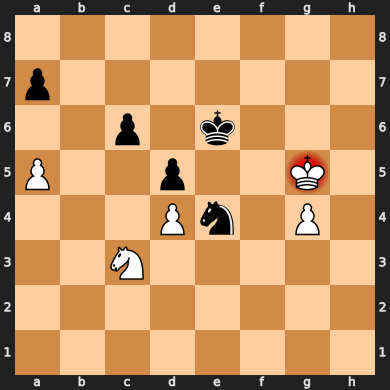

In [27]:
board = chess.Board(fen_string)
board

In [28]:
from stockfish import Stockfish

stockfish=Stockfish("StockFish/stockfish-windows-x86-64-avx2.exe")
stockfish.set_depth(20)#How deep the AI looks
stockfish.set_skill_level(20)#Highest rank stockfish
stockfish.get_parameters()

{'Debug Log File': '',
 'Contempt': 0,
 'Min Split Depth': 0,
 'Ponder': 'false',
 'MultiPV': 1,
 'Skill Level': 20,
 'Move Overhead': 10,
 'Minimum Thinking Time': 20,
 'Slow Mover': 100,
 'UCI_Chess960': 'false',
 'UCI_LimitStrength': 'false',
 'UCI_Elo': 1350,
 'Threads': 1,
 'Hash': 16}

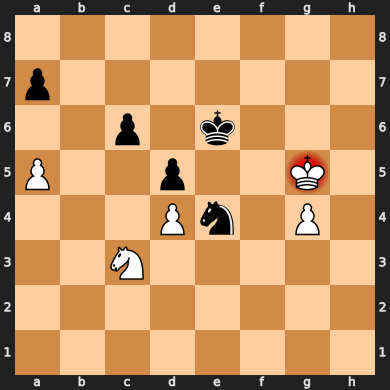

{'type': 'cp', 'value': 24}

In [29]:
display(board)
# stockfish.set_fen_position(board.fen())
stockfish.get_evaluation()

In [30]:
# board.turn = chess.WHITE
# board.push_san("c3e4")
# stockfish.set_fen_position(board.fen())
# stockfish.get_evaluation()

8/p7/2p1k3/P2p2K1/3Pn1P1/2N5/8/8 w - - 0 1


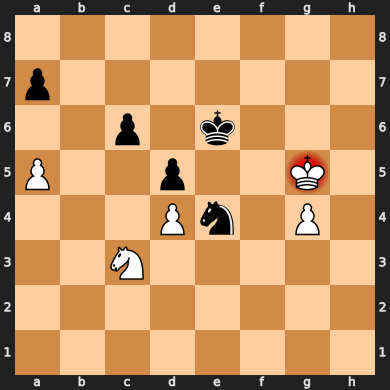

{'type': 'cp', 'value': 28}

In [31]:
print(board.fen())
display(board)
stockfish.get_evaluation()

In [32]:
# board.turn = chess.BLACK
# stockfish.set_fen_position(board.fen())
# print(board.fen())
# stockfish.get_evaluation()

In [33]:
stockfish.set_fen_position(board.fen())
top_moves = stockfish.get_top_moves(3)
top_moves

[{'Move': 'c3e4', 'Centipawn': 586, 'Mate': None},
 {'Move': 'g5f4', 'Centipawn': -626, 'Mate': None},
 {'Move': 'g5h4', 'Centipawn': -644, 'Mate': None}]

In [34]:
for move in top_moves:
    print(move['Move'][2:])
    print(move['Move'][:2])
    print("____")

e4
c3
____
f4
g5
____
h4
g5
____


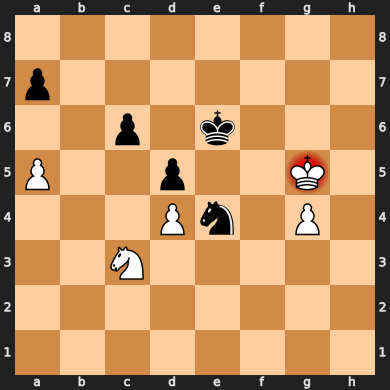

In [35]:
display(board)

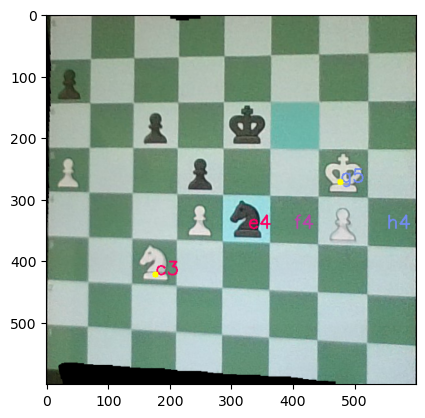

In [36]:
img_with_labels = mirrored_mask.copy()
for i in range(rows):
    for j in range(cols):
        # Calculate the top-left corner of the current cell
        x = i * cell_width
        y = j * cell_height

        # Generate the corresponding chessboard label
        label = columns[i] + rows_labels[j]

        # Place the label at the center of the cell
        text_x = x + cell_width // 2 - 10  # Adjust for text alignment
        text_y = y + cell_height // 2 + 10  # Adjust for text alignment
        C = 0
        for move in top_moves:
            if label == (move['Move'][2:]):
                cv2.putText(img_with_labels, label, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (C+100, C, 255-C), 2)
            if label == (move['Move'][:2]):
                cv2.putText(img_with_labels, label, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (C+100, C, 255-C), 2)
                cv2.circle(img_with_labels, (int(text_x), int(text_y)), 5, (0, 255, 255), -1)
            C+=70


plt.imshow(cv2.cvtColor(img_with_labels, cv2.COLOR_BGR2RGB))

In [52]:
#WITHOUT MASK

In [37]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import numpy as np
import os
from ultralytics import YOLO


0: 800x800 (no detections), 14.0ms
Speed: 5.0ms preprocess, 14.0ms inference, 1.0ms postprocess per image at shape (1, 3, 800, 800)


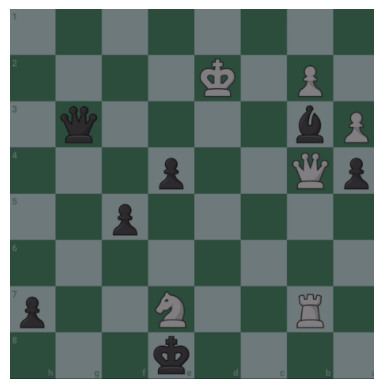

In [41]:
# Load the YOLO model
model_path = os.path.join('.', 'runs', 'segment', 'train_CB', 'weights', 'best.pt')
model = YOLO(model_path)

# Load the image
image_path = "C:/Users/Daithoulung Rongmai/Pictures/Screenshots/Screenshot 2024-10-22 011621.png"
img = Image.open(image_path)

# Run inference
results = model.predict(img, conf=0.8)

# Display results
for result in results:
    img_np = result.plot() if hasattr(result, 'plot') else result  
    plt.imshow(img_np)
    plt.axis('off')
    plt.show()




0: 800x800 1 black-bishop, 1 black-king, 4 black-pawns, 1 black-queen, 1 white-king, 1 white-knight, 2 white-pawns, 1 white-queen, 1 white-rook, 65.7ms
Speed: 9.0ms preprocess, 65.7ms inference, 2.0ms postprocess per image at shape (1, 3, 800, 800)


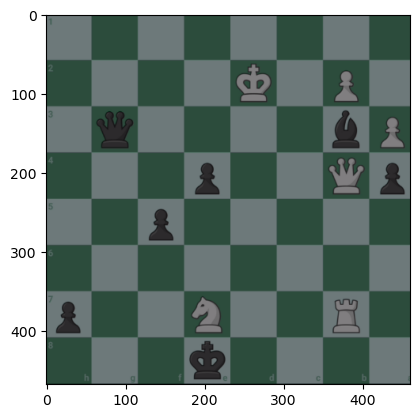

In [42]:
model_path = os.path.join('.', 'runs', 'detect', 'train_GCP', 'weights', 'best.pt')
model = YOLO(model_path)

results = model.predict(img_np, conf=0.3)

img_np1 = result.plot()
plt.imshow(img_np1)
# plt.axis('off')
plt.show()


(-0.5, 459.5, 467.5, -0.5)

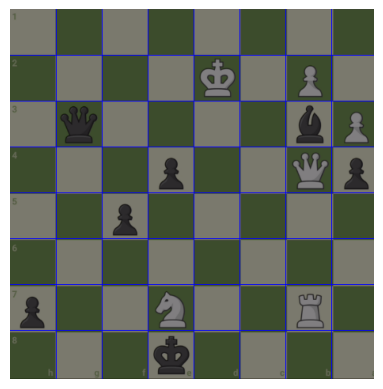

In [43]:

grid_size = 470  # We'll map the warped image to a 600x600 square

rows = 8
cols = 8

# Calculate the width and height of each cell in the grid
cell_width = grid_size // cols
cell_height = grid_size // rows

# Copy the warped image to draw the grid
img_with_grid = img_np.copy()

# Draw horizontal lines for the grid
for i in range(1, rows):
    y = i * cell_height
    cv2.line(img_with_grid, (0, y), (grid_size, y), (255, 0, 0), 1)  # Horizontal line

# Draw vertical lines for the grid
for i in range(1, cols):
    x = i * cell_width
    cv2.line(img_with_grid, (x, 0), (x, grid_size), (255, 0, 0), 1)  # Vertical line

# Display the warped image with the grid
plt.imshow(cv2.cvtColor(img_with_grid, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct display in Matplotlib
plt.axis('off')  # Remove axis for a clean display


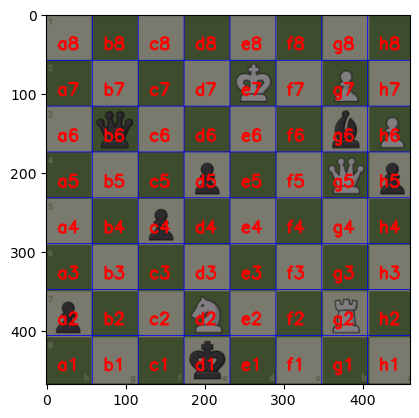

In [44]:
# Chessboard column labels ('a' to 'h') and row labels ('1' to '8')
columns = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
rows_labels = ['1', '2', '3', '4', '5', '6', '7', '8']

# Reverse the row labels to make sure bottom-left is 'a1'
rows_labels.reverse()

# Copy the warped image to draw labels
img_with_labels = img_with_grid.copy()

# Iterate over each cell in the grid
for i in range(rows):
    for j in range(cols):
        # Calculate the top-left corner of the current cell
        x = i * cell_width
        y = j * cell_height

        # Generate the corresponding chessboard label
        label = columns[i] + rows_labels[j]

        # Place the label at the center of the cell
        text_x = x + cell_width // 2 - 15  # Adjust for text alignment
        text_y = y + cell_height // 2 + 15  # Adjust for text alignment

        # Add the label to the image (white text with font size 1)
        cv2.putText(img_with_labels, label, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

# Display the warped image with grid and labels
plt.imshow(cv2.cvtColor(img_with_labels, cv2.COLOR_BGR2RGB))


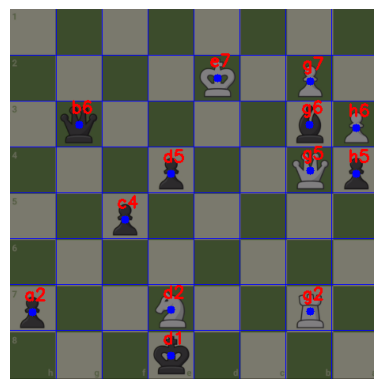

In [45]:
res = img_with_grid.copy()

piece_positions = {}

for result in results:
    boxes = result.boxes.xyxy.cpu().numpy()
    classes = result.boxes.cls.cpu().numpy()
    names = result.names
    for box,class_id in zip(boxes,classes):
        x_min,y_min,x_max,y_max = box
        center_x = (x_min + x_max) / 2
        center_y = ((y_min + y_max) / 2)
        
        grid_col = int(center_x // cell_width)
        grid_row = int(center_y // cell_height)
        
        if 0 <= grid_col < cols and 0 <= grid_row < rows:
            # Get the corresponding grid label
            grid_label = columns[grid_col] + rows_labels[grid_row]

            # Store the piece position and type in the dictionary
            piece_positions[grid_label] = names[int(class_id)]  # Correctly map label to class name
            
            cv2.circle(res, (int(center_x), int(center_y)), 5, (255, 0, 0), -1)
            cv2.putText(res, grid_label, (int(center_x)-10, int(center_y)-15), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        else:
            print(f"Center point ({center_x}, {center_y}) is outside the grid bounds.")

plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()



In [46]:
import chess

piece_map = {
    'white-rook': chess.Piece(chess.ROOK, chess.WHITE),
    'white-knight': chess.Piece(chess.KNIGHT, chess.WHITE),
    'white-bishop': chess.Piece(chess.BISHOP, chess.WHITE),
    'white-queen': chess.Piece(chess.QUEEN, chess.WHITE),
    'white-king': chess.Piece(chess.KING, chess.WHITE),
    'white-pawn': chess.Piece(chess.PAWN, chess.WHITE),
    'black-rook': chess.Piece(chess.ROOK, chess.BLACK),
    'black-knight': chess.Piece(chess.KNIGHT, chess.BLACK),
    'black-bishop': chess.Piece(chess.BISHOP, chess.BLACK),
    'black-queen': chess.Piece(chess.QUEEN, chess.BLACK),
    'black-king': chess.Piece(chess.KING, chess.BLACK),
    'black-pawn': chess.Piece(chess.PAWN, chess.BLACK),
}

# Create an empty chess board
board = chess.Board(None)  # None initializes an empty board

# Function to place pieces on the board
def set_up_board(board, piece_positions):
    for position, piece_description in piece_positions.items():
        piece = piece_map[piece_description]  # Get the chess library's piece object
        square = chess.parse_square(position)  # Convert 'a1' to the chess library's square index
        board.set_piece_at(square, piece)

# Set up the board using the piece_positions dictionary
set_up_board(board, piece_positions)

board.turn = chess.WHITE
# Generate the FEN string
fen_string = board.fen()


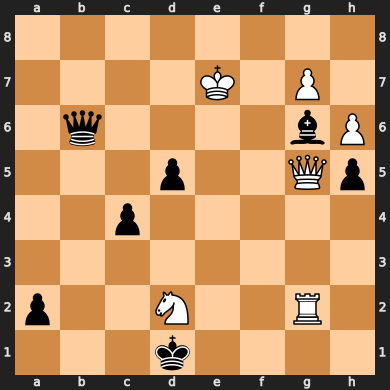

In [47]:
board = chess.Board(fen_string)
board

In [48]:
from stockfish import Stockfish

stockfish=Stockfish("StockFish/stockfish-windows-x86-64-avx2.exe")
stockfish.set_depth(20)#How deep the AI looks
stockfish.set_skill_level(20)#Highest rank stockfish
stockfish.get_parameters()

{'Debug Log File': '',
 'Contempt': 0,
 'Min Split Depth': 0,
 'Ponder': 'false',
 'MultiPV': 1,
 'Skill Level': 20,
 'Move Overhead': 10,
 'Minimum Thinking Time': 20,
 'Slow Mover': 100,
 'UCI_Chess960': 'false',
 'UCI_LimitStrength': 'false',
 'UCI_Elo': 1350,
 'Threads': 1,
 'Hash': 16}

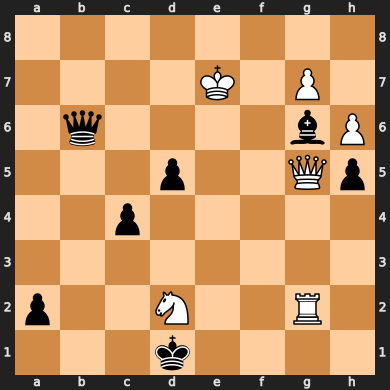

{'type': 'cp', 'value': 24}

In [49]:
display(board)
# stockfish.set_fen_position(board.fen())
stockfish.get_evaluation()

8/4K1P1/1q4bP/3p2Qp/2p5/8/p2N2R1/3k4 w - - 0 1


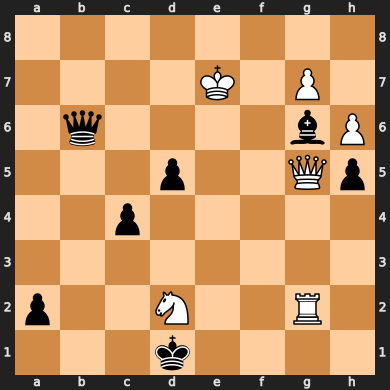

{'type': 'cp', 'value': 28}

In [50]:
print(board.fen())
display(board)
stockfish.get_evaluation()

In [51]:
stockfish.set_fen_position(board.fen())
top_moves = stockfish.get_top_moves(3)
top_moves

[{'Move': 'g2g1', 'Centipawn': 744, 'Mate': None},
 {'Move': 'g5d5', 'Centipawn': 730, 'Mate': None},
 {'Move': 'g5g6', 'Centipawn': 691, 'Mate': None}]

In [52]:
if (board.turn == chess.BLACK):
    board.turn = chess.WHITE
else:
    board.turn = chess.BLACK
    
stockfish.set_fen_position(board.fen())
top_moves = stockfish.get_top_moves(3)
top_moves

[{'Move': 'b6c7', 'Centipawn': 0, 'Mate': None},
 {'Move': 'b6b4', 'Centipawn': 0, 'Mate': None},
 {'Move': 'b6b7', 'Centipawn': 0, 'Mate': None}]

In [53]:
for move in top_moves:
    print(move['Move'][2:])
    print(move['Move'][:2])
    print("____")

c7
b6
____
b4
b6
____
b7
b6
____


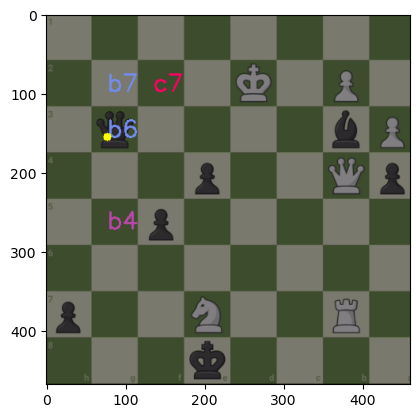

In [54]:
img_with_labels = img_np.copy()
for i in range(rows):
    for j in range(cols):
        # Calculate the top-left corner of the current cell
        x = i * cell_width
        y = j * cell_height

        # Generate the corresponding chessboard label
        label = columns[i] + rows_labels[j]

        # Place the label at the center of the cell
        text_x = x + cell_width // 2 - 10  # Adjust for text alignment
        text_y = y + cell_height // 2 + 10  # Adjust for text alignment
        C = 0
        for move in top_moves:
            if label == (move['Move'][2:]):
                cv2.putText(img_with_labels, label, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (C+100, C, 255-C), 2)
            if label == (move['Move'][:2]):
                cv2.putText(img_with_labels, label, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (C+100, C, 255-C), 2)
                cv2.circle(img_with_labels, (int(text_x), int(text_y)), 5, (0, 255, 255), -1)
            C+=70


plt.imshow(cv2.cvtColor(img_with_labels, cv2.COLOR_BGR2RGB))